In [1]:
import numpy as np
import os
from pathlib import Path
import json
from matplotlib import pyplot as plt
import matplotlib
from NeuralNetworkProj.Layers.ActivationFunctionLayers import Sigmoid, ReLu, Softmax
from NeuralNetworkProj.Layers.LossFuntionLayers import CrossEntropy
from NeuralNetworkProj.Layers.LinearLayer import LinearLayer
from NeuralNetworkProj.Utilities.InitalizationFunctions import normal_initializer

from NeuralNetworkProj.Utilities.DataTools import get_mnist_data,make_batches_idx,convert_dataset_numpy_array


In [2]:
train_data,test_data=get_mnist_data()

In [3]:
train_data.targets.shape

torch.Size([60000])

In [4]:
trn_data_label=convert_dataset_numpy_array(train_data)
# trn_data_label[0]=trn_data_label[0].reshape(-1,784)

tst_data_label=convert_dataset_numpy_array(test_data)
# tst_data_label[0]=tst_data_label[0].reshape(-1,784)

## Set random seed to produce same result

In [5]:
np.random.seed(0)

## Visualize data set

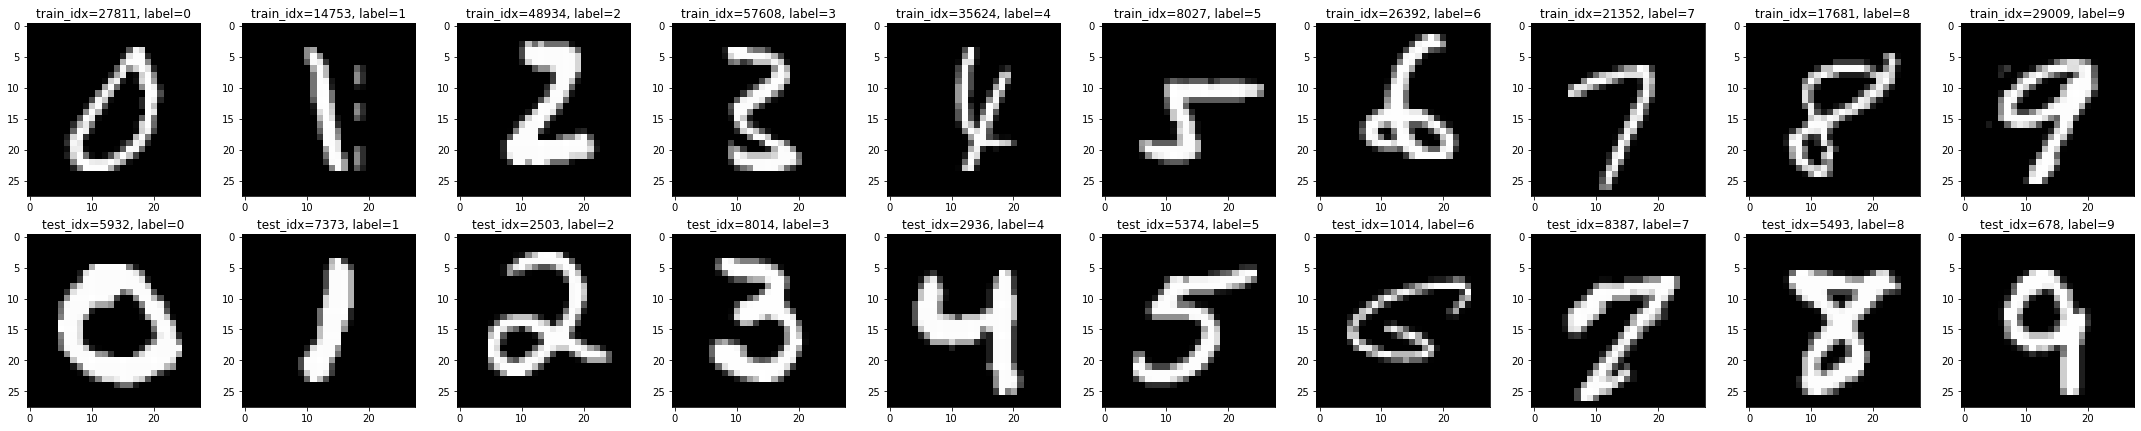

In [6]:
col=2
row=10
factor=3
fig=plt.figure("Visualzation of train test data",figsize=(row*factor,col*factor))
ax=fig.subplots(col,row)
dataset_name=["train","test"]
for i in range(10):
    indexes=[np.where(trn_data_label[1]==i)[0],np.where(tst_data_label[1]==i)[0]]
    j=0
    for dataset in [trn_data_label,tst_data_label]:
        idx=np.random.choice(indexes[j])
        ax[j][i].imshow(dataset[0][idx],cmap=plt.cm.gray)
        ax[j][i].set_title("{}_idx={}, label={}".format(dataset_name[j],idx,dataset[1][idx]))
        j+=1
fig.tight_layout()
fig.savefig("Images/VisualizationOfDataSet.png")

In [7]:
## Define network structure
in_feature=784
hidden_feature_1=40
hidden_feature_2=20
out_feature=10

bias_option=True

netowrk=[
    LinearLayer(input_size=in_feature,output_size=hidden_feature_1,initialization=normal_initializer,bias=bias_option),
    ReLu(),
    LinearLayer(input_size=hidden_feature_1,output_size=hidden_feature_2,initialization=normal_initializer,bias=bias_option),
    Sigmoid(),
    LinearLayer(input_size=hidden_feature_2,output_size=out_feature,initialization=normal_initializer,bias=bias_option),
    Softmax()
]

loss_criteria=CrossEntropy()

In [8]:
class Model():
    def __init__(self,model,updator) -> None:
        self.model=model
        self.updator=updator
    def __call__(self, x):
        input_=x
        for layer in self.model:
            input_=layer(input_)
        return input_

    def forward(self,x): # No recording method
        input_=x
        for layer in self.model:
            input_=layer.forward(input_)
        return input_

    def backward(self,grad):
        for layer in self.model[::-1]:
            grad=layer.backward(grad)
        return grad
    def Update(self):
        for layer in self.model:
            if not layer.require_update:
                continue
            seters=layer.parameter_seters()
            for name in layer.parameter_names():
                var_before=getattr(layer,name)
                grad_before=getattr(layer,name+"_grad")
                seters[name](self.updator(getattr(layer,name),getattr(layer,name+"_grad")))
                assert(np.allclose(getattr(layer,name),self.updator(var_before,grad_before)))
    
    def predict_prob(self,x):
        input_=x
        for layer in self.model:
            input_=layer.forward(input_) # avoid record data
        return input_
    
    def predict_label(self,x):
        prob=self.predict_prob(x)
        return np.argsort(prob,axis=1)[:,-1]

    def save_model(self,path):
        step=0
        folder=Path(path)
        if not folder.exists():
            folder.mkdir(parents=True)
        for layer in self.model:
            if layer.require_update:
                layer.save_model(str(folder/("layer_"+str(step))))
            step+=1

In [9]:
class LearningRate():
    def __init__(self,init_lr) -> None:
        self.lr=init_lr
    def get_lr(self):
        return self.lr

class NaiveUpdator():
    def __init__(self,lr:LearningRate) -> None:
        self.learning_rate=lr

    def __call__(self, variable,grad):
        return self.naive_updator(variable,grad)

    def naive_updator(self,variable,grad):
        return variable-self.learning_rate.get_lr()*grad

In [10]:
model=Model(netowrk,NaiveUpdator(LearningRate(0.001)))

In [11]:
def accuracy(x,label):
    return np.sum(x.ravel()==label.ravel())/len(label)

def loss_no_record(data_label,model,loss_fn):
    output=model(data_label[0].reshape(-1,784))
    return loss_fn.forward(output,data_label[1])

In [15]:
def train(trn_data_label,tst_data_label,model,loss_criteria,shuffle,batch_size,EPOCHES=100,start=0):
    losses={"train":[],"test":[]}
    accuracies={"train":[],"test":[]}
    for epoch in range(start,start+EPOCHES,1):
        indices=np.arange(len(trn_data_label[0]))
        if shuffle:
            np.random.shuffle(indices) # shuffle indices to introduce random
        batch_idx=make_batches_idx(indices,batch_size)
        total_loss=0
        step=0
        for batch in batch_idx:
            data=trn_data_label[0][batch].reshape(batch_size,-1)
            target=trn_data_label[1][batch]
            
            output=model(data)
            loss_val=loss_criteria(output,target)
            grad=loss_criteria.backward()
            # print(grad)
            model.backward(grad)
            model.Update()
            total_loss+=loss_val
            if step%10==0:
                print("Epoch {} Batch {}/{} \r".format(epoch,step,len(batch_idx)),end="")
            step+=1
        if epoch%10==0:
            losses["train"].append([epoch,total_loss/len(batch_idx)])
            accuracies["train"].append([epoch,accuracy(model.predict_label(trn_data_label[0].reshape(len(trn_data_label[0]),784)),trn_data_label[1])])
            losses["test"].append([epoch,loss_no_record(tst_data_label,model,loss_criteria)])
            accuracies["test"].append([epoch,accuracy(model.predict_label(tst_data_label[0].reshape(len(tst_data_label[0]),784)),tst_data_label[1])])
        
        if epoch%10==0:
            model.save_model("result/model_epoch"+str(epoch))
        print("Epoch {}, loss {}".format(epoch,total_loss/len(batch_idx)))
    model.save_model("result/model_epoch"+str(epoch))
    losses["train"].append([epoch,total_loss/len(batch_idx)])
    accuracies["train"].append([epoch,accuracy(model.predict_label(trn_data_label[0].reshape(len(trn_data_label[0]),784)),trn_data_label[1])])
    losses["test"].append([epoch,loss_no_record(tst_data_label,model,loss_criteria)])
    accuracies["test"].append([epoch,accuracy(model.predict_label(tst_data_label[0].reshape(len(tst_data_label[0]),784)),tst_data_label[1])])
    return {"loss":losses,"acc":accuracies }


In [16]:
output=train(trn_data_label,tst_data_label,model,loss_criteria,False,60,100,101)


Epoch 101, loss 1.081251424805644
Epoch 102, loss 1.0620652045566943
Epoch 103, loss 1.0589778810805137
Epoch 104, loss 1.0560832344748952
Epoch 105, loss 1.0517761558136955
Epoch 106, loss 1.0461874241116746
Epoch 107, loss 1.0366588713821696
Epoch 108, loss 1.0304933605602207
Epoch 109, loss 1.0290236525961276
Epoch 110, loss 1.0261286864553036
Epoch 111, loss 1.0248984047170704
Epoch 112, loss 1.0178293501996842
Epoch 113, loss 1.0236580870422896
Epoch 114, loss 1.0142014247438984
Epoch 115, loss 1.0182559700838643
Epoch 116, loss 1.0142341520902554
Epoch 117, loss 1.0101770479333587
Epoch 118, loss 1.0004297432999196
Epoch 119, loss 0.9934005170510877
Epoch 120, loss 0.9923008803996698
Epoch 121, loss 0.9876715323551606
Epoch 122, loss 0.9853336773963793
Epoch 123, loss 0.9877890454558231
Epoch 124, loss 0.9838146088260483
Epoch 125, loss 0.977284147087547
Epoch 126, loss 0.9712962804287407
Epoch 127, loss 0.9695078339657638
Epoch 128, loss 0.964570790904941
Epoch 129, loss 0.96042

In [14]:
with open("./result/result.json","w") as fout:
    json.dump(output,fout)